In [1]:
import os
from pathlib import Path
import sys
import numpy as np
import scvelo as scv

In [2]:
notebook_dir = os.getcwd()
notebook_dir

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\STVelo\\notebooks\\analysis\\nuc_cyto_vs_spl_uns'

In [4]:
Path(notebook_dir).parents[3]

WindowsPath('c:/Users/OmerCagatayTalikaci/Desktop/github')

In [5]:
os.chdir(Path(notebook_dir).parents[3])

In [6]:
stvelo_path = os.path.join(os.getcwd(),'STVelo','stvelo')

In [7]:
import sys  
sys.path.insert(1,stvelo_path)
from pipelines.simulate_3ode import *
from pipelines.metrics import *
from pipelines.preprocessing import Preprocessing
from pipelines.compute_velocity import Velocities

In [34]:
n_cells=800
n_genes=300
t_max=20 #### maybe could be fix?

config_simulation = {'parameters':{ 'n_obs':300,
    'n_vars':None,
    'alpha':None,
    'beta':None,
    'nu' :None,
    'gamma':None,
    'alpha_':None,
    't_max':20,
    'noise_model':"normal",
    'noise_level':1,
    'switches': None}, {'options'}: {'save':False}}


############## CONFIG PREPROCESSING #####################
config_preprocessing = {'preprocess_params': { 'min_counts': 200, 'min_cells': 5, 'n_neighbors': 23, 'n_pcs': 0, 'min_dist': 1},
'functions_to_apply': {'filter_cells': True,  'filter_genes': True,   'normalize_total': True,  'log1p': True,
'pca': True,   'neighbors': True,   'umap': True,   'leiden': True,   'moments': True}}

############## CONFIG VELOCITY #####################
# config_velocity = { 'velocity_types': ['dynamical','deterministic','stochastic','velovi']}
config_velocity = { 'velocity_types': ['deterministic']}

############# CONFIG PLOTTING ######################



In [22]:
import numpy as np

# Mean vector (log-transformed)
mu = np.array([np.log(10), np.log(1), np.log(0.5), np.log(0.1)])

# Standard deviations
sigma = np.array([0.5, 0.3, 0.3, 0.4])

# Correlation matrix
corr = np.array([
    [1,    0.6,  0.3, -0.4],
    [0.6,  1,    0.5, -0.2],
    [0.3,  0.5,  1,   -0.3],
    [-0.4, -0.2, -0.3, 1]
])

# Covariance matrix
cov = np.outer(sigma, sigma) * corr

# Verify positive semi-definiteness
eigenvalues = np.linalg.eigvals(cov)
if np.all(eigenvalues >= 0):
    print("Covariance matrix is positive semi-definite.")
else:
    print("Covariance matrix is not positive semi-definite. Adjusting correlations...")

    # Adjust correlations slightly if needed
    # For example, reduce correlations by a small factor

# Sample from multivariate normal
sample = np.random.multivariate_normal(mu, cov, size = 300)

# Exponentiate to get parameter values
params = np.exp(sample)
alpha, beta, nu, gamma = params.T



Covariance matrix is positive semi-definite.


In [26]:
def switch_times(t_max, n_vars):
    lower_bound = 0.05 * t_max
    upper_bound = 0.8 * t_max

    
    uniform_array = np.random.uniform(lower_bound, upper_bound, n_vars)

    return uniform_array

In [27]:
s = switch_times(20,300)

In [29]:
save_data_path = os.path.join(os.getcwd(),"outputs","data")
save_data_path

'c:\\Users\\OmerCagatayTalikaci\\Desktop\\github\\outputs\\data'

In [30]:

adata_dict = simulation_3ode(n_obs=800,alpha=alpha, beta= beta, nu=nu, gamma=gamma, t_max=20, switches=s/20,n_vars=300,save=True,saving_path=save_data_path)

In [33]:
for key, adata in adata_dict.items():
    print(f'{key} is being preprocessed.')
    preprocessor = Preprocessing(adata,config_preprocessing)
    adata = preprocessor.preprocess_data()

adata_s_u is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
adata_n_c is being preprocessed.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [35]:
velocity_computer = Velocities(adata_dict,config_velocity)

Using device: cuda


In [36]:
adata_dict_velocity = velocity_computer.compute_velocities()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [37]:
scv.tl.velocity_graph(adata_dict_velocity["adata_n_c_deterministic"])

computing velocity graph (using 1/24 cores)
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


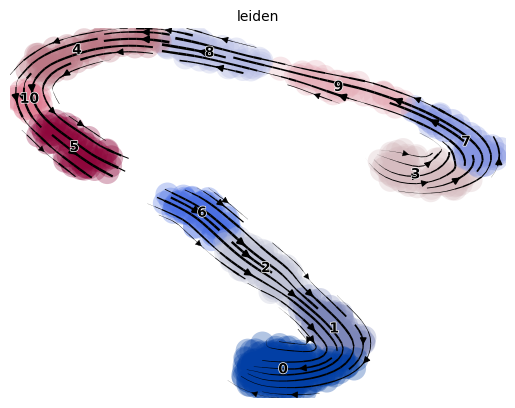

In [41]:
scv.pl.velocity_embedding_stream(adata_dict_velocity["adata_n_c_deterministic"],basis="umap",color="leiden")